# ROSA QA demo
This notebook demos our experiments with Question answering for documentation search with ROSA. The training set here all the public documents available. The results here reflect how the models will perform in deployment when it has access to all the data. For validation, we use a FAQ document present in the documentation dataset for ROSA.  This exercise reveals how the models will perform if they have access to the exact answer.  You will need to provide the api key as the `OPENAI_API_KEY` environment variable to execute this notebook the open-ai api based llms. You can place the key in a `credentials.env` at the root of this repository and this notebook will load it in the following cell. For an example, look at the `credentials_example.env` file.

## Import dependencies and credentials

In [2]:
# Import package

import pandas as pd

import re
from sklearn.metrics import f1_score
import nltk

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownTextSplitter
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.prompts.prompt import PromptTemplate

from dotenv import load_dotenv, find_dotenv
import pandas as pd
import time
pd.set_option('display.max_colwidth', None)

/opt/anaconda3/envs/fm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv(find_dotenv("credentials.env"), override=True)

True

## Load all the documents in a vectorstore

In [21]:
loader = DirectoryLoader('../data/external', glob="**/*.md", loader_cls=TextLoader)
documents = loader.load()

In [22]:
## Verification
'../data/external/rosaworkshop/14-faq.md' in [i.metadata['source'] for i in documents]

True

In [23]:
## Split the documents into chunks. Is there a better way than hardcoding size as 1000?
text_splitter = MarkdownTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

In [24]:
embeddings = OpenAIEmbeddings()

In [25]:
docsearch = Chroma.from_documents(texts, embeddings, persist_directory='../data/interim')
#docsearch.persist()

Running Chroma using direct local API.
No existing DB found in ../data/interim, skipping load
No existing DB found in ../data/interim, skipping load


## Solution 1: Documentation Search
In this next section, we demonstrate an embedding based approach to search within the documentation of the ROSA product. The algorithm takes user queries and looks for relevant content in the product documents. The _relevance_ is determined by vector similarilty in the embedding space. Then, it fetches the top k excerpts and the markdown document that has the probability of having the answer. The end user would see the top k relevant documents to their query and click on the page that they think answers their query. 
The benefits of these approach is that it is that it requires less resources to integrate with existing workflows. The reasons for that are: 
* Since it is not generative text, it is easier to evaluate the correctness of the approach
* The CPU, GPU, memory, and disk requirements of this approach would be less than hosting a llm
* This notebook uses OpenAI embedding API but there are comparable open source alternatives that can be adapted for this task

In [11]:
# Fetch the evaluation dataset 
eval_dataset = pd.read_csv('../data/processed/validation_data.csv')[['Question', 'Answer']]
questions = eval_dataset['Question'].tolist()

In [98]:
# Get relevant documents for the questions
data = list()
for q in questions:
    docs = docsearch.similarity_search(q, 5)
    data.append([q, docs[0].page_content, docs[0].metadata['source'],
                 docs[1].page_content, docs[1].metadata['source'],
                 docs[2].page_content, docs[2].metadata['source'],
                 docs[3].page_content, docs[3].metadata['source'],
                 docs[4].page_content, docs[4].metadata['source'],
                 ])

In [119]:
# Create a dataframe with the top 5 texts and sources
s1_answers = pd.DataFrame(data=data, columns=['question', 'A1-text', 'A1-source',
                                              'A2-text', 'A2-source',
                                              'A3-text', 'A3-source',
                                              'A4-text', 'A4-source',
                                              'A5-text', 'A5-source',
                                              ])
s1_answers.head(1)

,question,A1-text,A1-source,A2-text,A2-source,A3-text,A3-source,A4-text,A4-source,A5-text,A5-source
0,What is Red Hat OpenShift Service on AWS (ROSA)?,"# Understanding ROSA\n\nLearn about Red Hat OpenShift Service on AWS (ROSA), interacting with ROSA using Red Hat OpenShift Cluster Manager and command-line interface (CLI) tools, consumption experience, and integration with Amazon Web Services (AWS) services.",../data/external/rosa-docs/rosa_architecture.md,"About ROSA\n\nROSA is a fully-managed, turnkey application platform that allows you to focus on delivering value to your customers by building and deploying applications. Red Hat and AWS Site reliability engineering (SRE) experts manage the underlying platform so you do not have to worry about the complexity of infrastructure management. ROSA provides seamless integration with a wide range of AWS compute, database, analytics, machine learning, networking, mobile, and other services to further accelerate the building and delivering of differentiating experiences to your customers.\n\nYou subscribe to the service directly from your AWS account. After the clusters are created, you can operate your clusters with the OpenShift web console or through Red Hat OpenShift Cluster Manager. The ROSA service also uses OpenShift APIs and command-line interface (CLI) tools. These tools provide a standardized OpenShift experience to use your existing skills and tools knowledge.",../data/external/rosa-docs/rosa_architecture.md,Red Hat OpenShift Service on AWS service definition\n\nThis documentation outlines the service definition for the Red Hat OpenShift Service on AWS (ROSA) managed service.,../data/external/rosa-docs/rosa_architecture.md,"General\n\n### What is Red Hat OpenShift Service on AWS (ROSA)?\nRed Hat Openshift Service on AWS (ROSA) is a fully-managed turnkey application platform that allows you to focus on what matters most, delivering value to your customers by building and deploying applications. Red Hat SRE experts manage the underlying platform so you don’t have to worry about the complexity of infrastructure management.\n\n### Where can I go to get more information/details?\n- [ROSA Webpage](https://www.openshift.com/products/amazon-openshift)\n- [ROSA Workshop](https://www.rosaworkshop.io)\n- [ROSA Documentation](https://docs.openshift.com/rosa/welcome/index.html)",../data/external/rosaworkshop/14-faq.md,"What are the differences between Red Hat OpenShift Service on AWS and Kubernetes?\nEverything you need to deploy and manage containers is bundled with ROSA, including container management, automation (Operators), networking, load balancing, service mesh, CI/CD, firewall, monitoring, registry, authentication, and authorization capabilities. These components are tested together for unified operations as a complete platform. Automated cluster operations, including over-the-air platform upgrades, further enhance your Kubernetes experience.",../data/external/rosaworkshop/14-faq.md


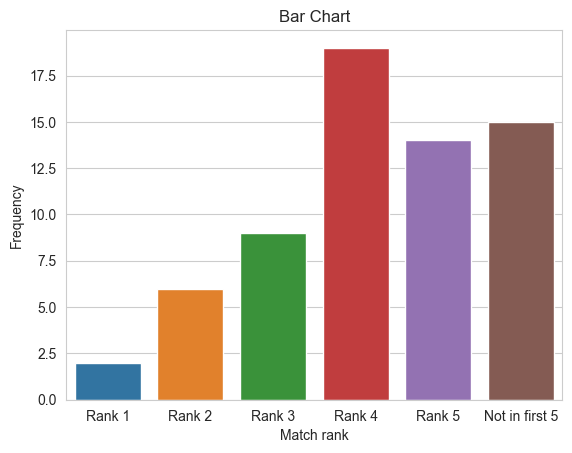

In [116]:
# Analyze results of the documentation search
ans_doc = "../data/external/rosaworkshop/14-faq.md"
c1, c2, c3, c4, c5, c0 = 0, 0, 0, 0, 0, 0
for i, row in s1_answers.iterrows():
    if ans_doc in row['A1-source']:c1+=1
    elif ans_doc in row['A2-source']:c2+=1
    elif ans_doc in row['A3-source']:c3+=1
    elif ans_doc in row['A4-source']:c4+=1
    elif ans_doc in row['A5-source']:c5+=1
    else: c0+=1
# Define the data
x = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5', 'Not in first 5']
y = [2, 6, 9, 19, 14, 15]

# Set the Seaborn style
sns.set_style('whitegrid')

# Create the bar chart using Seaborn
sns.barplot(x=x, y=y)

# Add some labels and titles
plt.xlabel('Match rank')
plt.ylabel('Frequency')
plt.title('Bar Chart')

# Show the plot
plt.show()

### Next steps for documents retrieval
* Calculate Mean reciprocal rank and improve the ranks of the documents retrieved
* Create a more comprehensive testing set including questions that are semantically similar but syntatically different with FAQ questions

## Solution 2: Answer Generation after documentation search

In the next section, we will demonstrate a text generation approach to answer questions. The algorithm takes user queries and generates the answer word by word. Each word in the output is conditioned on the input and the previous output words. This approach builds on the embedding based search and uses its result to provide context as a part of the input to the generative model. The benefits of the model are:
* Users don't have to search for the answer in a document
* It has a chat like capability to iteratively refine informaton retrieval

The challenges with this approach are:
* Generation can be grammatically correct but factually incorrect
* It requires intesive compute
* It is an emerging space with rapid changes in technology

In [18]:
chain = load_qa_with_sources_chain(OpenAI(temperature=0), chain_type="stuff")

In [19]:
def answer_question(query, index, chain):
    """
    Takes in query, index to search from, and llm chain to generate answer
    """
    ## Retrieve docs
    docs = index.similarity_search(query)
    ## Generate answer
    answer = chain({"input_documents": docs, "question": query}, return_only_outputs=True)
    return answer['output_text']

### Generate answers for the FAQ dataset questions 

In [16]:
questions = eval_dataset['Question'].tolist()
real_answers = eval_dataset['Answer'].tolist()
generated_answers = list()
i=1
for query in questions:
    answer = answer_question(query, docsearch, chain)
    generated_answers.append(answer)
    ## Add delay to avoid rate limit error
    time.sleep(1)
    print(f"{i}/{len(eval_dataset)} done")
    i+=1
    
eval_dataset['generated_answers'] = generated_answers

1/65 done
2/65 done
3/65 done
4/65 done
5/65 done
6/65 done
7/65 done
8/65 done
9/65 done
10/65 done
11/65 done
12/65 done
13/65 done
14/65 done
15/65 done
16/65 done
17/65 done
18/65 done
19/65 done
20/65 done
21/65 done
22/65 done
23/65 done
24/65 done
25/65 done
26/65 done
27/65 done
28/65 done
29/65 done
30/65 done
31/65 done
32/65 done
33/65 done
34/65 done
35/65 done
36/65 done
37/65 done
38/65 done
39/65 done
40/65 done
41/65 done
42/65 done
43/65 done
44/65 done
45/65 done
46/65 done
47/65 done
48/65 done
49/65 done
50/65 done
51/65 done
52/65 done
53/65 done
54/65 done
55/65 done
56/65 done
57/65 done
58/65 done
59/65 done
60/65 done
61/65 done
62/65 done
63/65 done
64/65 done
65/65 done


In [ ]:
# Save data for analysis
eval_dataset.to_csv("../data/results/openai-0/generated-answers.csv")

### Qualitative Evaluation

Next, we tried qualitatively evaluating the outputs of the model: 

Example 1
- Question: _What exactly am I responsible for and what is Red Hat / AWS responsible for?_ 
- Actual Answer: "In short, anything that is related to deploying the cluster or keeping the cluster running will be Red Hat’s or AWS’s responsibility, and anything relating to the applications, users, or data is the customers responsibility.  Please see our [responsibility matrix](https://docs.openshift.com/rosa/rosa_architecture/rosa_policy_service_definition/rosa-policy-responsibility-matrix.html) for more details."
- Generated Answer:   Anything related to deploying the cluster or keeping the cluster running is Red Hat's or AWS's responsibility, and anything relating to the applications, users, or data is the customer's responsibility. Please see the responsibility matrix for more details.
- **Observations: The answer is correct here but the link to the document is missing.**

Example 2
- Question: _Do I need to sign/have a contract with Red Hat?_ 
- Actual Answer: "No. You do not need to have a contract with Red Hat to use ROSA. You will need a Red Hat account for use on console.redhat.com which includes accepting our Enterprise Agreement and Online services terms."
- Generated Answer:   No, you do not need to sign/have a contract with Red Hat.
- **Observations: The answer is correct but a subset of the actual answer. Model outputs are brief and partially correct frequently. They are exact responses to the prompts, for example they wouldn’t include links and descriptions if the input prompt doesn’t ask for them.**

Example 3
- Question: _Where can I go to get more information/details?_ 
- Actual Answer: "[ROSA Webpage](https://www.openshift.com/products/amazon-openshift)..."
- Generated Answer:  You can find more information and details on the Home page of the OCM UI, which includes links to additional resources.
- **Observations: If the input questions are out of context and they don’t mention ROSA, it’ll be very hard to get sensible answers. In the original FAQ document, they had a context that they belonged to the ROSA workshop FAQ document but here the context is not available.**

Example 4
- Question: _Which compliance certifications does ROSA have so far?_
- Actual Answer: Red Hat OpenShift Service on AWS is currently compliant with SOC-1, SOC-2 type 1 & type 2, ISO-27001, & PCI-DSS. We are also currently working towards FedRAMP High, HIPAA, ISO 27017 and ISO 27018 as well.
- Generated Answer: ROSA has not yet obtained any compliance certifications.
- **Observation: The answer is completely incorrect here.**


Some other examples that we evaluated can be seen in here ([1](https://docs.google.com/spreadsheets/d/1XQUn9IgzVXxTQxRdVWG7xfQOuowGIFLorXECKUKi16w/edit#gid=8386486),[2](https://docs.google.com/spreadsheets/d/1Z0m4FqRsWfV4PDWDZSK3vhSyf8sth7IUBAaFW7x-6mw/edit#gid=1290796759))

We also have the quantitaitve metrics in the metrics notebook.

The answers can be improved by writing tailored prompts for the task. There are different ways of prompt engineering and some of them are listed here [1](https://learn.microsoft.com/en-us/azure/cognitive-services/openai/concepts/prompt-engineering):
* Primary content or the system prompt or the main instruction: Adding a detailed context around the problem and assigning a persona to the model
* Few-shot learning: Adding to show how the output looks 
* Cue: Adding a "jumpstart" phrase or cue to help the model generate the answer
* Fallback: Adding an instruction for what to do when the model doesn't know the answer
* Best practices: Adding instructions that are specific, descriptive, chronological, and emphasizes important aspects

### Prompt Generation
The prompt was written following these prompt engineering [guidelines](https://learn.microsoft.com/en-us/azure/cognitive-services/openai/concepts/prompt-engineering) and chat GPT. The template for this will be added to the repository. 

In [128]:
template = """
You are a support engineer who is trying to generate answers for questions around the ROSA product. Your goal is to answer questions that ROSA customers and users would find relevant, informative, and useful. You should be descriptive and provide links to support your answer. 

Here is a description of the product:
ROSA is a fully-managed, turnkey application platform that allows you to focus on delivering value to your customers by building and deploying applications. You can learn more about it in the documentaion here: https://docs.openshift.com/rosa/welcome/index.html

Here are a few input and output pairs examples to guide the model:

Input: "What is Red Hat OpenShift Service on AWS (ROSA)?"
Output: "Red Hat Openshift Service on AWS (ROSA) is a fully-managed turnkey application platform that allows you to focus on what matters most, delivering value to your customers by building and deploying applications. Red Hat SRE experts manage the underlying platform so you don’t have to worry about the complexity of infrastructure management."

Input: "Where can I go to get more information/details?"
Output: "You can find more information at the following links [ROSA Webpage](https://www.openshift.com/products/amazon-openshift)
- [ROSA Workshop](https://www.rosaworkshop.io)
- [ROSA Documentation](https://docs.openshift.com/rosa/welcome/index.html)"


If you don't know the answer, please respond with: "I'm sorry, I don't have enough information to generate that content.
Please help this ROSA customer to find the answer to this {question} given the relevant content around the question {context}:
"""

prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=template,
)
chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff", prompt=prompt)

In [130]:
eval_dataset = pd.read_csv('../data/processed/validation_data.csv')[['Question', 'Answer']]
questions = eval_dataset['Question'].tolist()
real_answers = eval_dataset['Answer'].tolist()
generated_answers = list()
i=1
for query in eval_dataset['Question'].tolist():
    answer = answer_question(query, docsearch, chain)
    generated_answers.append(answer)
    ## Add delay to avoid rate limit error
    time.sleep(1)
    print(f"{i}/{len(eval_dataset)} done")
    i+=1
    
eval_dataset['generated_answers'] = generated_answers

1/65 done
2/65 done
3/65 done
4/65 done
5/65 done
6/65 done
7/65 done
8/65 done
9/65 done
10/65 done
11/65 done
12/65 done
13/65 done
14/65 done
15/65 done
16/65 done
17/65 done
18/65 done
19/65 done
20/65 done
21/65 done
22/65 done
23/65 done
24/65 done
25/65 done
26/65 done
27/65 done
28/65 done
29/65 done
30/65 done
31/65 done


In [ ]:
# Save data for analysis
eval_dataset.to_csv("../data/results/openai-1/generated-answers.csv")

### Qualitative evaluation

In [67]:
qs = ["What exactly am I responsible for and what is Red Hat / AWS responsible for?",
             "Do I need to sign/have a contract with Red Hat?",
             "Where can I go to get more information/details?",
             "Which compliance certifications does ROSA have so far?"]

eval_dataset[eval_dataset['Question'].isin(qs)]['generated_answers'].to_list()

['\n- [Adding support contacts](https://docs.openshift.com/rosa/4.5/managing_clusters/adding_support_contacts.html)\n\n#### Configuration examples\n\nYou can find configuration examples for ROSA in the [documentation](https://docs.openshift.com/rosa/4.5/configuring_clusters/configuring_clusters.html).\n\n#### Pricing\n\nYou can find pricing information for ROSA on the [Red Hat OpenShift Service on AWS](https://www.openshift.com/products/amazon-openshift) page.',
 '\nRed Hat OpenShift Service on AWS is managed by Red Hat SRE experts who will monitor and maintain the underlying platform so you don’t have to worry about the complexity of infrastructure management. Red Hat will also provide support for the OpenShift software component.',
 '\nYes, all Red Hat OpenShift Service on AWS 4.8 clusters require an administrator acknowledgment before they can be upgraded to Red Hat OpenShift Service on AWS 4.9. This acknowledgment is required to ensure that the customer is aware of the changes and 

Example 1
- Question: _What exactly am I responsible for and what is Red Hat / AWS responsible for?_ 
- Actual Answer: "In short, anything that is related to deploying the cluster or keeping the cluster running will be Red Hat’s or AWS’s responsibility, and anything relating to the applications, users, or data is the customers responsibility.  Please see our [responsibility matrix](https://docs.openshift.com/rosa/rosa_architecture/rosa_policy_service_definition/rosa-policy-responsibility-matrix.html) for more details."
- Generated Answer: Red Hat OpenShift Service on AWS is managed by Red Hat SRE experts who will monitor and maintain the underlying platform so you don’t have to worry about the complexity of infrastructure management. Red Hat will also provide support for the OpenShift software component.'
- **Observations: The answer is partially correct, it doesn't go into user responsibilities.**

Example 2
- Question: _Do I need to sign/have a contract with Red Hat?_ 
- Actual Answer: "No. You do not need to have a contract with Red Hat to use ROSA. You will need a Red Hat account for use on console.redhat.com which includes accepting our Enterprise Agreement and Online services terms."
- Generated Answer:  Yes, all Red Hat OpenShift Service on AWS 4.8 clusters require an administrator acknowledgment before they can be upgraded to Red Hat OpenShift Service on AWS 4.9. This acknowledgment is required to ensure that the customer is aware of the changes and new features that are included in the upgrade. The acknowledgment can be found in the Red Hat OpenShift Service on AWS console.',
- **Observations: It is incorrect as it understands it as a contract for upgrade.**

Example 3
- Question: _Where can I go to get more information/details?_ 
- Actual Answer: "[ROSA Webpage](https://www.openshift.com/products/amazon-openshift)..."
- Generated Answer:  [Adding support contacts](https://docs.openshift.com/rosa/4.5/managing_clusters/adding_support_contacts.html)\n\n#### Configuration examples\n\nYou can find configuration examples for ROSA in the [documentation](https://docs.openshift.com/rosa/4.5/configuring_clusters/configuring_clusters.html).\n\n#### Pricing\n\nYou can find pricing information for ROSA on the [Red Hat OpenShift Service on AWS](https://www.openshift.com/products/amazon-openshift) page.
- **Observations: The links are different and two of them don't work.**

Example 4
- Question: _Which compliance certifications does ROSA have so far?_
- Actual Answer: Red Hat OpenShift Service on AWS is currently compliant with SOC-1, SOC-2 type 1 & type 2, ISO-27001, & PCI-DSS. We are also currently working towards FedRAMP High, HIPAA, ISO 27017 and ISO 27018 as well.
- Generated Answer: For more information, please refer to the [Red Hat OpenShift Service on AWS documentation](https://docs.openshift.com/rosa/welcome/index.html)
- **Observation: The answer is not incorrect here.**

Overall, the questions that lacked context have better answers but there are still incorrect responses. Let's try tweaking the prompt.

### Another tweak with reduced noise in the prompt

In [ ]:
template = """
You are a support engineer generating answers for questions around the Red Hat Openshift Service on AWS (ROSA) product. 
Your goal is to answer questions that ROSA customers and users would find correct and useful. 
You should be descriptive and provide documentation web links to support your answer. 

Here are a few input and output pairs examples to guide the model:

I am a ROSA user and I want to know the answer to this question: "What is Red Hat OpenShift Service on AWS (ROSA)?"
Answer: "Red Hat Openshift Service on AWS (ROSA) is a fully-managed turnkey application platform that allows you to focus on what matters most, delivering value to your customers by building and deploying applications. Red Hat SRE experts manage the underlying platform so you don’t have to worry about the complexity of infrastructure management."

I am a ROSA user and I want to know the answer to this question:: "Where can I go to get more information/details?"
Answer: "You can find more information at the following links [ROSA Webpage](https://www.openshift.com/products/amazon-openshift)
- [ROSA Workshop](https://www.rosaworkshop.io)
- [ROSA Documentation](https://docs.openshift.com/rosa/welcome/index.html)"


If you don't know the answer, please respond with: "I'm sorry, I don't have enough information to generate that content.
Use the above guidelines to answer the following question:
I am a ROSA user and I want to know the answer to this question {question}. You can use the {context} for help.
Answer:
"""

prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=template,
)
chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff", prompt=prompt)

In [ ]:
eval_dataset = pd.read_csv('../data/processed/validation_data.csv')[['Question', 'Answer']]
questions = eval_dataset['Question'].tolist()
real_answers = eval_dataset['Answer'].tolist()
generated_answers = list()
i=1
for query in questions:
    answer = answer_question(query, docsearch, chain)
    generated_answers.append(answer)
    ## Add delay to avoid rate limit error
    time.sleep(1)
    print(f"{i}/{len(eval_dataset)} done")
    i+=1

1/65 done
2/65 done
3/65 done
4/65 done
5/65 done
6/65 done
7/65 done
8/65 done
9/65 done
10/65 done
11/65 done
12/65 done
13/65 done
14/65 done
15/65 done
16/65 done
17/65 done
18/65 done
19/65 done
20/65 done
21/65 done
22/65 done
23/65 done
24/65 done
25/65 done
26/65 done
27/65 done
28/65 done
29/65 done
30/65 done
31/65 done
32/65 done
33/65 done
34/65 done
35/65 done
36/65 done
37/65 done
38/65 done
39/65 done
40/65 done
41/65 done
42/65 done
43/65 done
44/65 done
45/65 done
46/65 done
47/65 done
48/65 done
49/65 done
50/65 done
51/65 done
52/65 done
53/65 done
54/65 done
55/65 done
56/65 done
57/65 done
58/65 done
59/65 done
60/65 done
61/65 done
62/65 done
63/65 done
64/65 done
65/65 done


In [ ]:
eval_dataset['generated_answers'] = generated_answers
eval_dataset.to_csv("../data/results/openai-2/generated-answers.csv")

Example 1
- Question: _What exactly am I responsible for and what is Red Hat / AWS responsible for?_ 
- Actual Answer: "In short, anything that is related to deploying the cluster or keeping the cluster running will be Red Hat’s or AWS’s responsibility, and anything relating to the applications, users, or data is the customers responsibility.  Please see our [responsibility matrix](https://docs.openshift.com/rosa/rosa_architecture/rosa_policy_service_definition/rosa-policy-responsibility-matrix.html) for more details."
- Generated Answer: 'Red Hat OpenShift Service on AWS (ROSA) is a fully-managed turnkey application platform that allows you to focus on what matters most, delivering value to your customers by building and deploying applications. Red Hat SRE experts manage the underlying platform so you don’t have to worry about the complexity of infrastructure management. \n\nWhen you provision ROSA clusters, you will incur the infrastructure and OpenShift charges at the pay-as-you-go hourly rate. Red Hat and AWS are responsible for the monitoring and maintenance of the ROSA cluster, while the customer is responsible for the applications, workloads, and data that they deploy to the cluster. For more information, please refer to our [responsibility matrix](https://docs.openshift.com/rosa/rosa_architecture/rosa_policy_service_definition/rosa-policy-responsibility-matrix.html) and [pricing page](https://www.openshift.com/products/amazon-openshift/pricing).'
- **Observations: The answer is correct and comprehensive**

Example 2
- Question: _Do I need to sign/have a contract with Red Hat?_ 
- Actual Answer: "No, you do not need to sign/have a contract with Red Hat to use ROSA. You will need a Red Hat account for use on console.redhat.com which includes accepting our Enterprise Agreement and Online services terms. All Red Hat OpenShift Service on AWS 4.8 clusters require this administrator acknowledgment before they can be upgraded to Red Hat OpenShift Service on AWS 4.9. For more information, please refer to the [ROSA Documentation](https://docs.openshift.com/rosa/welcome/index.html)',
- **Observations: The first part of the answer is completely correct. Although it adds irrelevant information.**

Example 3
- Question: _Where can I go to get more information/details?_ 
- Actual Answer: "[ROSA Webpage](https://www.openshift.com/products/amazon-openshift)..."
- Generated Answer: You can find more information about obtaining support for Red Hat OpenShift Service on AWS (ROSA) at the following links: \n- [ROSA Home Page](../../#resources)\n- [Adding Support Contacts](https://docs.openshift.com/rosa/4.5/managing_clusters/managing_cluster_support_contacts.html)\n- [ROSA Documentation](https://docs.openshift.com/rosa/welcome/index.html)'.
- **Observations: The links are different and two of them don't work.**

Example 4
- Question: _Which compliance certifications does ROSA have so far?_
- Actual Answer: Red Hat OpenShift Service on AWS is currently compliant with SOC-1, SOC-2 type 1 & type 2, ISO-27001, & PCI-DSS. We are also currently working towards FedRAMP High, HIPAA, ISO 27017 and ISO 27018 as well.
- Generated Answer: No, all nodes in a Red Hat OpenShift Service on AWS cluster must be located in the same AWS region; this follows the same model as that of OCP. For clusters configured for multiple availability zones control plane nodes and worker nodes will be distributed across the availability zones. For more information, please refer to the [Red Hat OpenShift Service on AWS documentation](https://docs.openshift.com/rosa/welcome/index.html).
- **Observation: The answer is incorrect here.**

The prompt needs to be refined further for this domain.

## Conclusion

In this work, we generated answers using the OpenAI language model and evaluated their quality against the ground truth answers for a set of questions in the FAQ document.  We discussed two approaches: embedding search and text generation. 

The next steps here are to improve the results we obtained with both the approaches. Parallely, we want to think about the tools and pipeling required to bring the first version in front of support engineers. Additionally, we would require more examples of question and answers around ROSA. 